# About Dataset

Apologies for the confusion. The COCO Captioning 2017 dataset is a subset of the larger COCO dataset that focuses specifically on image captioning. It contains a collection of over 123,000 images, each accompanied by five human-generated captions.

The images in the COCO Captioning 2017 dataset cover a wide range of scenes, objects, and activities. They are carefully selected to ensure diversity in terms of content, visual complexity, and context. The dataset includes images from various sources, such as professional photographers and online platforms, ensuring a broad representation of real-world scenarios.

The captions provided in the dataset are detailed and descriptive, capturing the essence of the images. Each image is associated with five different captions, allowing for multiple variations in textual descriptions. The captions are written by human annotators who carefully analyze the images to produce accurate and contextually relevant descriptions.

The COCO Captioning 2017 dataset has become a benchmark for evaluating image captioning algorithms. Researchers and practitioners use this dataset to train and evaluate their models for the task of automatically generating captions for images. The dataset facilitates fair comparisons between different approaches, enabling advancements in the field of image captioning.

By providing a large-scale collection of diverse images and high-quality captions, the COCO Captioning 2017 dataset has played a crucial role in driving research and development in the area of automatic image captioning. It has served as a valuable resource for training and testing models, fostering innovation, and pushing the boundaries of image understanding and natural language generation.

# Import libraries


In [1]:
import numpy as np
import random
from typing import Callable, Dict, List, Optional, Tuple, Union
import torch.nn.init as init
import torch.nn.functional as F
import multiprocessing as mp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import ViTFeatureExtractor, ViTModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model, GPT2Config
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define Models

In [22]:
# Load Models That We need
# Load pre-trained ViT model and distil gpt2 language model
# Create a ViT feature extractor
device = torch.device("cpu")
VIT_model =  ViTModel.from_pretrained('google/vit-base-patch16-224', ignore_mismatched_sizes=True)
language_model2 = GPT2LMHeadModel.from_pretrained("distilgpt2", add_cross_attention = True)
language_model2.to(device)

# Add the cross-attention configuration
gpt2_config = GPT2Config.from_pretrained("distilgpt2")
gpt2_config.add_cross_attention = True
gpt2_config.cross_attention = CrossAttentionLayer(hidden_size=gpt2_config.hidden_size,num_attention_heads=gpt2_config.num_attention_heads)

language_model = GPT2LMHeadModel(config=gpt2_config)


# make sure GPT2 appends EOS in begin and end
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs

GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
# set pad_token_id to unk_token_id -> be careful here as unk_token_id == eos_token_id == bos_token_id
tokenizer.pad_token = tokenizer.unk_token

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are new

# Defines a collate_fn function
collate_fn function that takes a batch as input. It iterates over each item in the batch, which consists of an image and a list of captions. It appends each image to the images list and extracts the captions from each caption dictionary, adding them to the captions list.

In [4]:
def collate_fn(batch):
    images = []
    captions = []
    for image, captions_list in batch:
        # Add the image to the list of images
        images.append(image)

        # Add the list of captions to the list of captions
        caption_texts = [caption_dict['caption'] for caption_dict in captions_list]
        captions.append(caption_texts)

    # Convert the list of images to a tensor of shape (batch_size, C, H, W)
    images_tensor = torch.stack(images, dim=0)

    # Return a tuple of (images_tensor, captions)
    return images_tensor, captions

# Defines a function to load_preprocessed_coco_dataset:
The code defines a function load_preprocessed_coco_dataset that takes batch_size as input. It sets up transformations for the images using transforms.Compose, including resizing the images to (224, 224) and converting them to tensors.

Next, it loads the COCO train dataset using the CocoDetection class with the specified root directory and annotation file, along with the defined transformations.

The code calculates the number of samples to select, which is 50% of the dataset length. It creates a list of indices for the dataset and shuffles them using random.shuffle. Then, it selects the first 50% of the shuffled indices to create a subset of the dataset.

A DataLoader is created for the subset, specifying the batch size, shuffle option, collate function (collate_fn from the previous code snippet), and the number of worker processes to load the data in parallel.

Similarly, the COCO validation dataset is loaded using CocoDetection with the appropriate root directory, annotation file, and transformations.

Finally, a DataLoader is created for the validation dataset, using the same specifications as the training data loader.

The function returns the training and validation data loaders.

In [7]:
def load_preprocessed_coco_dataset(batch_size):
    # Define transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    # Load the COCO train dataset
    coco_train = CocoDetection(root="/home/azimi/COCO dataset/train2017", annFile='/home/azimi/annotations/captions_train2017.json', transform=transform)

    # Calculate the number of samples to select (15% of the dataset)
    num_samples_to_select = int(len(coco_train) * 0.15)

    # Get all the indices of the dataset
    indices = list(range(len(coco_train)))

    # Shuffle the indices
    random.shuffle(indices)

    # Select the first 10% of the shuffled indices
    selected_indices = indices[:num_samples_to_select]

    # Create a Subset of the dataset using the selected indices
    subset_train = torch.utils.data.Subset(coco_train, selected_indices)

    # Create a DataLoader for the subset
    dataloader_train = DataLoader(subset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=mp.cpu_count())
    
    # Load the COCO val dataset
    coco_val = CocoDetection(root='/home/azimi/COCO dataset/val2017', annFile='/home/azimi/annotations/captions_val2017.json', transform=transform)
    
    # Create a PyTorch DataLoader for the COCO val dataset
    dataloader_val = DataLoader(coco_val, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=mp.cpu_count())
    
    return dataloader_train, dataloader_val

In [8]:
dataloader_train, dataloader_val = load_preprocessed_coco_dataset(batch_size=4)

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


# Sampling 
Now we load one sample image and corresponding captions of it.

torch.Size([4, 3, 224, 224])


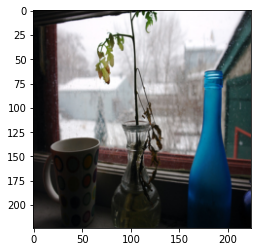

['A mug, vase, and blue glass bottle in front of a winder', 'A window sill line with vases and plants.', 'Vases displayed near window pane, showing snowy landscape', 'a vase that is next to a window', 'The shot is taken of the 3 objects in the window with the snow cover of winter outside.']


In [9]:
# Get a batch of images and captions from the training DataLoader
images, captions = next(iter(dataloader_train))

# Print the shape of the images tensor
print(images.shape)



#Display the first image in the batch
plt.imshow(images[0].permute(1, 2, 0))
plt.show()

# Print the first caption in the batch
print(captions[0])

# Define Tokenizer
The code processes a list of captions and performs the following steps:

It initializes empty lists input_ids, attention_masks, and labels to store the processed data.

It iterates over each item in captions.

Within each iteration, it randomly selects a caption from the current item.

It tokenizes the caption twice using tokenizer. The first tokenization is stored in caption_tokenized1, and the second tokenization is stored in caption_tokenized2.

It extracts the input_ids from caption_tokenized1, which represent the tokenized input sequence.

It extracts the attention_mask from caption_tokenized2, which indicates which tokens should be attended to (1) and which should be ignored (0).

It assigns the input_ids to label_id, which will later be modified based on the attention mask.

It loops through the attention_mask and checks for tokens with a value of 0. For such tokens, it sets the corresponding value in label_id to -100.


In [10]:
def tokenizing_captions(captions):

    input_ids = []
    attention_masks = []
    labels = []
    for item in captions:
        caption = random.choice(item)
        caption_tokenized1 = tokenizer(caption , max_length=18, padding="max_length", truncation=True, add_special_tokens=True)
        caption_tokenized2 = tokenizer(caption , max_length=18, padding="max_length", truncation=True, add_special_tokens=True)
        input_id=caption_tokenized1["input_ids"]
        attention_mask = caption_tokenized2["attention_mask"]
        label_id = caption_tokenized2["input_ids"]
        for i, item in enumerate(attention_mask):
            if item == 0:
                label_id[i]= -100
        
        labels.append(label_id)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
    input_ids = torch.tensor(input_ids)
    labels = torch.tensor(labels)
    attention_masks = torch.tensor(attention_masks)

    return input_ids , attention_masks, labels

In [11]:
captiontok, captionatt, labels = tokenizing_captions(captions)
print("Tokenized Captions Input_ids:\n", captiontok)
print("Tokenized Captions Attention masks:\n", captionatt)
print("Tokenized Captions As My Labels:\n", labels)

Tokenized Captions Input_ids:
 tensor([[50256,    32, 25152,    11,   410,   589,    11,   290,  4171,  5405,
          9294,   287,  2166,   286,   257,  2344,   263, 50256],
        [50256,    32, 14256,   319,   257,  3084,   351,   257,  9396,   286,
         36656,   290, 11758,    13, 50256, 50256, 50256, 50256],
        [50256,    32,  2415,  5586,   379,   257,  3084,   351,   257,   220,
         14256,   287,  2166,   286,   607,    13, 50256, 50256],
        [50256,    32,  1448,   286, 22575,  2491,   832,   257,  8701,  2214,
         46753,    13, 50256, 50256, 50256, 50256, 50256, 50256]])
Tokenized Captions Attention masks:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])
Tokenized Captions As My Labels:
 tensor([[50256,    32, 25152,    11,   410,   589,    11,   

# Define Image Encoder:
It uses a torch.no_grad() context to disable gradient computation, as we don't need gradients for inference.

It passes the images through a VIT (Vision Transformer) model, denoted as VIT_model, to obtain the embedded image features. The result is stored in image_features_embedded.

Finally, it returns the first element of image_features_embedded.

In [12]:
def encoding_images(images):
 
    with torch.no_grad():
        image_features_embedded = VIT_model(images)

    return image_features_embedded[0]

In [13]:
encoder_outputs = encoding_images(images)
encoder_outputs.size()

torch.Size([4, 197, 768])

# Language model output
Get output of language model for one batch

In [17]:
outputs = language_model2(input_ids = captiontok, attention_mask=captionatt, encoder_hidden_states=encoder_outputs, labels=labels)

In [18]:
outputs.loss

tensor(4.4198, grad_fn=<NllLossBackward0>)

# Training
In the training section, first we encode the images through the image encoding function and also prepare our labels, input Ids and attention masks through the tokenizing function and then feed these as our inputs to the language model and then we start to compute loss and upadate our models parameters, actually we want to train our cross attention layer that we added it to our language model.

In [23]:
# Define training parameters
batch_size = 4
num_epochs = 3
learning_rate = 0.0001

# Define loss function and optimizer
optimizer = torch.optim.AdamW(language_model2.parameters(), lr=learning_rate)

In [24]:
# Define lists to store losses
train_losses = []
val_losses = []

# Define training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    num_train_batches = len(dataloader_train)
    pbar1 = tqdm(dataloader_train, desc=f'Epoch {epoch}', unit='batch')

    # Training phase
    for batch_images, batch_captions in pbar1:
        optimizer.zero_grad()
        # Preprocess images and captions
        encoder_outputs1 = encoding_images(batch_images)
        input_ids1, attention_mask1, labels1 = tokenizing_captions(batch_captions)
        
        # Feed input through language model and compute loss
        outputs1 = language_model2(input_ids=input_ids1, attention_mask=attention_mask1, encoder_hidden_states=encoder_outputs1, labels=labels1)
        loss1 = outputs1.loss
        
        # Backpropagate and update parameters
        loss1.backward()
        optimizer.step()
        
        train_loss += loss1.item()
        pbar1.set_postfix({'Training Loss': loss1.item()})
        
    pbar1.close()
   
    
    # Calculate average training loss for the epoch
    train_loss /= num_train_batches
    
    # Validation phase
    val_loss = 0.0
    num_val_batches = len(dataloader_val)
    pbar2 = tqdm(dataloader_val, desc=f'Epoch {epoch}', unit='batch')

    for batch_images, batch_captions in pbar2:
        # Preprocess images and captions
        encoder_outputs2 = encoding_images(batch_images)
        input_ids2, attention_mask2, labels2 = tokenizing_captions(batch_captions)

        # Disable gradient calculation
        with torch.no_grad():
            # Feed input through language model and compute loss
            outputs2 = language_model2(input_ids=input_ids2, attention_mask=attention_mask2, encoder_hidden_states=encoder_outputs2, labels=labels2)
            loss2 = outputs2.loss
            
            val_loss += loss2.item()
            pbar2.set_postfix({'Validation Loss': loss2.item()})
        
    pbar2.close()

    # Calculate average validation loss for the epoch
    val_loss /= num_val_batches
    
    # Print epoch losses
    print(f'Epoch {epoch} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}')

Epoch 0: 100%|██████████| 1250/1250 [13:39<00:00,  1.53batch/s, Validation Loss=2.76]


Epoch 0 | Train Loss: 2.6659 | Validation Loss: 2.5116


Epoch 1: 100%|██████████| 1250/1250 [09:45<00:00,  2.13batch/s, Validation Loss=2.5] 


Epoch 1 | Train Loss: 2.3933 | Validation Loss: 2.4221


Epoch 2: 100%|██████████| 1250/1250 [09:30<00:00,  2.19batch/s, Validation Loss=1.76]

Epoch 2 | Train Loss: 2.2549 | Validation Loss: 2.3826


# Saving Model

In [68]:
# Saving trained model
torch.save(language_model2.state_dict(), "trained_model2.pth")

# Load Model

In [17]:
# Create an instance of the model
language_model2 = GPT2LMHeadModel(config=gpt2_config)

# Load the saved model state dict
state_dict = torch.load("trained_model2.pth")

# Load the state dict into the model
language_model2.load_state_dict(state_dict)

# Make sure to put the model in evaluation mode
language_model2.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (crossattention): GPT2Attention(
          (c_attn): Conv1D()
          (q_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_cross_attn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
      

# Generation Progress
In this section we want to generate captions for our 15 random images in validation set.

## Load Validation Set

In [25]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])
coco_val = CocoDetection(root='/home/azimi/COCO dataset/val2017', annFile='/home/azimi/annotations/captions_val2017.json', transform=transform)
dataloader_val = DataLoader(coco_val, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=mp.cpu_count())
val_images, val_captions = next(iter(dataloader_val))
val_images_encodings = encoding_images(val_images)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


## Nucleus Sampling
In nucleus sampling, instead of selecting the next word based on a fixed probability threshold, it involves selecting from a subset, or "nucleus," of the most probable words. The size of this subset is determined by a probability threshold, usually denoted as "p" or "k."

Here's how nucleus sampling works in practice:

Generate the probabilities for each word in the vocabulary for the next word prediction, based on the model's output and context.

Sort the words in descending order of their probabilities.

Calculate the cumulative probabilities for the sorted words until the sum exceeds the specified threshold (p or k).

Select all the words up to the point where the cumulative probability exceeds the threshold.

Randomly sample from this narrowed-down set of words based on their original probabilities to determine the next word.

Nucleus sampling helps to strike a balance between randomness and coherence in the generated text. It allows for the selection of a diverse range of words while still maintaining some control over the likelihood of each word.

By adjusting the threshold value, you can control the "creativity" of the model's responses. Higher values of p or k result in more deterministic and focused responses, while lower values introduce more randomness and novelty.

This technique has been effective in improving the output quality of language models and making their responses more varied and interesting.

In [26]:
def top_k_top_p_filtering(
    next_token_logits: torch.FloatTensor,
    top_k: Optional[float]=None, 
    top_p: Optional[float]=None,
) -> torch.FloatTensor:
    if top_k is None:
        top_k = next_token_logits.shape[-1]
    if top_p is None:
        top_p = 1.0
        
    p, largest_p_idx = F.softmax(next_token_logits, dim=-1).topk(top_k, dim=-1)
    cumulative_p = p.cumsum(dim=-1)
    threshold_repeated = top_p + torch.zeros((len(p),1))
    idx = torch.searchsorted(cumulative_p, threshold_repeated).clip(max=top_k-1).squeeze()
    cutoffs = cumulative_p[torch.arange(len(cumulative_p)), idx]
    censored_p = (cumulative_p <= cutoffs[:, None]) * p
    renormalized_p = censored_p / censored_p.sum(dim=-1, keepdims=True)
    
    final_p = torch.zeros_like(next_token_logits)
    row_idx = torch.arange(len(p)).unsqueeze(1).repeat(1,top_k)
    final_p[row_idx, largest_p_idx] = renormalized_p.to(final_p.dtype)

    return final_p

## Captioning

In [27]:
def image_captioning(encoder_outputs, max_text_length):
    generated_so_far = torch.LongTensor([[tokenizer.bos_token_id]]*len(encoder_outputs))
    with torch.no_grad():
        for _ in range(max_text_length):
            attention_mask = torch.ones_like(generated_so_far)
            decoder_out = language_model2(input_ids=generated_so_far, attention_mask=attention_mask, encoder_hidden_states=encoder_outputs)
            next_token_logits = decoder_out["logits"][:, -1, :]
            filtered_p = top_k_top_p_filtering(next_token_logits, top_k=100, top_p=0.95)
            next_token = torch.multinomial(filtered_p, num_samples=1)
            generated_so_far = torch.cat((generated_so_far, next_token), dim=1)
    return [tokenizer.decode(coded_sentence) for coded_sentence in generated_so_far]

In [28]:
generated_sentences=image_captioning(encoder_outputs=val_images_encodings, max_text_length=18)

In [ ]:
# Create a function to convert image tensors to plots
def tensor_to_plot(image_tensor):
    # Plot the image
    
    plt.imshow(image_tensor.permute(1, 2, 0))
    plt.axis('off')  # Turn off the axes
    plt.tight_layout()  # Adjust spacing
    plt.show()

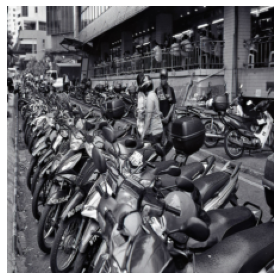

Actual Captions: ['This is an image of a row of scooters', 'This black and white photo shows many motorcycles parked next to each other', 'long line of motorcycles near the edge of a building', 'Several people near a lot holding a huge quantity of motorcycles.', 'a huge group of motor cycles sitting on the street']
Generated Captions: <|endoftext|>People getting on scooters in a crowded parking lot<|endoftext|>There are many lots of<|endoftext|><|endoftext|>


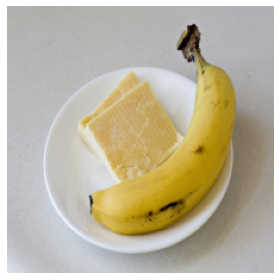

Actual Captions: ['A plate with a banana and slices of cheese.', 'A banana sitting on top of a white plate next to a pastry.', 'A banana is couple with sliced cheese on a plate.', 'There is a banana and two pieces of cheese on a plate.', 'A white plate with two slices of cheese and a whole banana unpealed.']
Generated Captions: <|endoftext|>a banana sits in  a mug of a mug <|endoftext|>Grown bread <|endoftext|><|endoftext|>


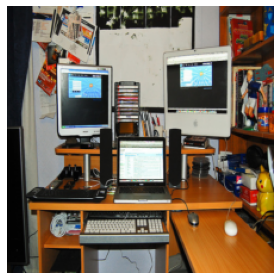

Actual Captions: ['Laptop with computer monitors displayed on wooden desk.', 'Three computers are shown at the wooden desk.', 'a desktop setup with a laptop and two monitors', 'An office desk with two computer monitors and one laptop.', 'a desk with two monitors and a laptop on it ']
Generated Captions: <|endoftext|>Some kind of computer and some computers on a desk.<|endoftext|>A desk.<|endoftext|><|endoftext|><|endoftext|>


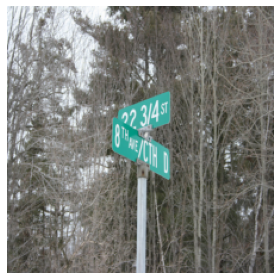

Actual Captions: ['Street signs from the corner of 8th ave. and 22 3/4 st.', 'A two way street sign with one sign that changes from one name to another.', 'A street sign is pointing towards 8th avenue and the other is pointing towards 22 3/4 street in the middle of the forest.', 'A street sign standing in front of some trees.', 'Peculiar street sign showing intersection of 23 3/4 St and 8th Ave/CTH D.']
Generated Captions: <|endoftext|>Some white street signs and trees. <|endoftext|>Street signs against a tree.<|endoftext|><|endoftext|><|endoftext|>


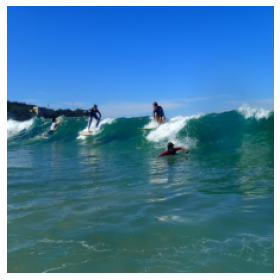

Actual Captions: ['some people are riding surfboards on a wave', 'Two people surf as two others are bodyboarding on a wave. ', 'Four surfers are trying to catch a wave as they stand.', 'Several people are riding the waves on their surfboards.', 'Several people on surfboards who are riding a wave.']
Generated Captions: <|endoftext|>Several surfers riding skis out the ocean.<|endoftext|>WeSurF's water<|endoftext|><|endoftext|>


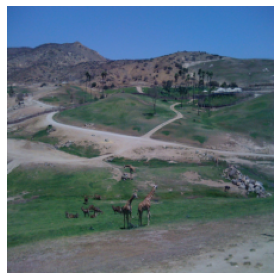

Actual Captions: ['An African type landscape with giraffes, wildebeests and antelope.', 'Dirt roads on a hilly landscape with giraffes and antelope in the foreground.', 'Two giraffes walking along a trail to the hills.', 'A large grassy field with giraffes and a few other animals.', 'Some giraffes in a field near some mountains. ']
Generated Captions: <|endoftext|>A group of cows are in a grassy area.<|endoftext|>Pair of cattle<|endoftext|><|endoftext|>


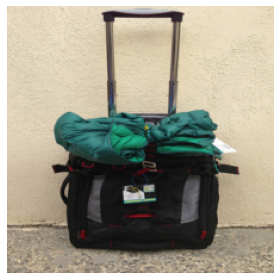

Actual Captions: ['A piece of luggage is ready to go with cold wear on top for quick usage.', 'A luggage for travel is stuffed with a down jacket.', 'A piece of luggage sitting on the outside of a white building.', 'A carry on rolling luggage with stuff bursting out the top.', 'A wheel along back pack with a jacket strapped to the top']
Generated Captions: <|endoftext|>A suit case has been piled in to of a car trunk.<|endoftext|>Looking outside<|endoftext|><|endoftext|>


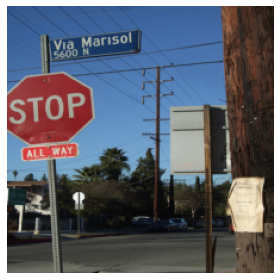

Actual Captions: ['A stop sign with a street sign above it.', 'A street signs is on top of the stop sign', 'A red sign letting drivers know to stop. ', 'there is a stop sign and a street sign at the corner ', 'An intersection with traffic and street signs on it. ']
Generated Captions: <|endoftext|>A stop sign against a stop sign that there is the street name.<|endoftext|>THIS<|endoftext|><|endoftext|>


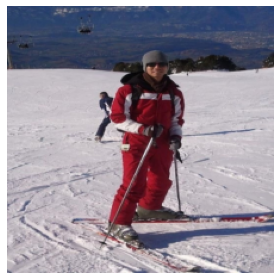

Actual Captions: ['A man standing in snow gear on skis while on a snowy hill.', 'A man riding skis on top of  a snow covered hill.', 'A skier is standing and posing for a photo', 'a person riding skis on a snowy surface', 'A man poses while skiing on a mountain at a snow resort. ']
Generated Captions: <|endoftext|>Several people on skis on a snow covered slope next to a mountain.<|endoftext|><|endoftext|><|endoftext|>


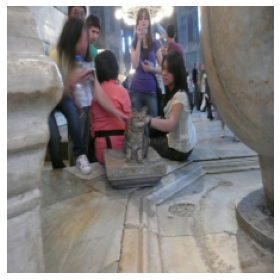

Actual Captions: ['People in a hall with a camera taking a picture', 'a group of people that are petting a cat', 'A group of people sitting around petting a cat.', 'A group of women siting around a cat as they pet it.', 'People are sitting on the ground petting a cat.']
Generated Captions: <|endoftext|>A statue of an elephant for children younger than age<|endoftext|><|endoftext|>There is a statue<|endoftext|><|endoftext|>


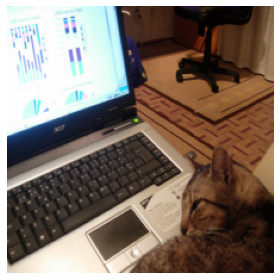

Actual Captions: ['A brown and black cat laying on laptop next to a chair.', 'A cat is curled up next to a laptop computer.', 'A cat sleeping on the edge of a laptop computer. ', 'A cat curled up by the keyboard of a laptop.', 'Cat sleeping in front of a powered on laptop computer.']
Generated Captions: <|endoftext|>A cat sitting on a chair reading someone with a laptop screen<|endoftext|>A cat laying<|endoftext|><|endoftext|>


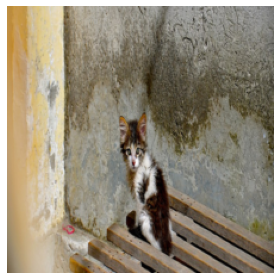

Actual Captions: ['A spotted kitten sitting on a wooden bench.', 'A small kitten sitting on a slatted bench.', 'Small kitten sitting on a small wooden table.', 'Small kitten sitting on top of a wooden crate. ', 'A small kitten sitting on a pallet of wood looking back.']
Generated Captions: <|endoftext|>An animal laying down in a floor next to a brick wall.<|endoftext|>Cat and<|endoftext|><|endoftext|>


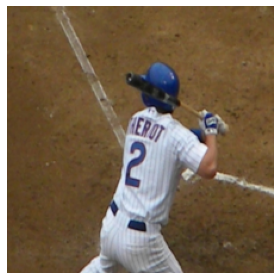

Actual Captions: ['A person on a field with a baseball bat.', 'a baseball player on a base ball field holding a bat', 'A baseball player is getting ready for a pitch.', 'There is a man holding a baseball bat in his hands.', 'a man is holding a baseball bat at a game']
Generated Captions: <|endoftext|>A baseball player looking at a batter during a swing.<|endoftext|>A baseball.<|endoftext|><|endoftext|><|endoftext|>


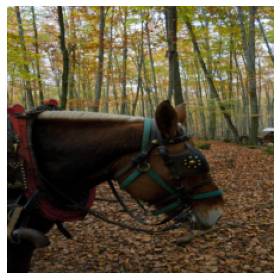

Actual Captions: ['A horse with blinder and a colorful harness in the woods', 'A brown horse walking through a leaf covered forest.', 'A horse that is in the dirt by trees.', 'A bridled mule stands in front of trees and leaves. ', 'Horse with blinders on walking through wooded area']
Generated Captions: <|endoftext|>A grey horse sitting on top of a flat tree.<|endoftext|>The man is posing<|endoftext|><|endoftext|>


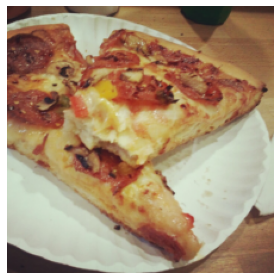

Actual Captions: ['A paper plate that has two pieces of pizza on it.', 'There are two slices of pizza on a paper plate.', 'A couple of slices of pizza on top of a white plate.', 'Two slices of pizza sitting on a paper plate.', 'Two slices of pizza are sitting on a paper plate.']
Generated Captions: <|endoftext|>A pizza with two slices of pizza sits on a paper plate.<|endoftext|>LOOK<|endoftext|><|endoftext|>


In [67]:
for i in range(15):
    tensor_to_plot(val_images[i])
    print("Actual Captions:", val_captions[i])
    print("Generated Captions:", generated_sentences[i])